# **Walmart Recruiting - Store Sales Forecasting**

We are provided historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and we are tasked with predicting the department-wide sales for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

## **Data:**
The dataset essentially contains five scv files which are descibed as follows.
https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data

**stores.csv:**

  This file contains anonymized information about the 45 stores, indicating      the type and size of store.

**train.csv:**

  This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file we will find the following fields:

  - Store - the store number
  - Dept - the department number
  - Date - the week
  - Weekly_Sales -  sales for the given department in the given store
  - IsHoliday - whether the week is a special holiday week

**test.csv:**

 This file is identical to train.csv, except we have withheld the weekly sales. We must predict the sales for each triplet of store, department, and date in this file.

**features.csv:**

 This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

  - Store - the store number
  - Date - the week
  - Temperature - average temperature in the region
  - Fuel_Price - cost of fuel in the region
  - MarkDown1 to MarkDown5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
  - CPI - the consumer price index
  - Unemployment - the unemployment rate
  - IsHoliday - whether the week is a special holiday week

**sampleSubmission.csv:**

We have been provided with dates where we can predict the salesfor each date mentioned in this csv file.

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

  - Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
  -Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
  - Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
  - Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

**Evaluation:**

 This competition is evaluated on the weighted mean absolute error (WMAE):
 >$WMAE = [1/(sum_{i=1}^n w_i]) \sum_{i=1}^n \ w_i|y_i - y_i^{hat}|$

 where
 * n is the number of rows
 * $y_i^{hat}$  is the predicted sales
 * $y_i$  is the actual sales
 * $w_i$  are weights, w = 5 if the week is a holiday week, 1 otherwise


**WHY WMAE ONLY CHOOSEN AS  A PERFORMANCE METRIC:**

1)
.First of all we have see why we have not used RMSE as a performance metric here as it is most famous one then also we preferred MAE over it because of following reasons :
•	The Dataset given is not large dataset so the impact of outlier points will impact more than usual. So, RMSE can increase the impact of outliers double almost.
•	Lets take an example of two model:

M1 with points    : 11,11,11,110

M2 with points     : 14,14,,14,106

Actual points are :  10,10,10,100

RMSE of M1=  1/4*(sqrt(1+1+1+100))   =2.54

RMSE of M2=  1/4*(sqrt(16+16+16+36))=2.29

MAE of M1   =  1/4*(1+1+1+10) =3.25

MAE of M2   =  1/4*(4+4+4+6) =4.5

So, we can clearly see that RMSE of M1> RMSE of M2 and 
MAE of M1< MAE of M2  and actually my model 1 is better as all outputs are close to actual one except one but RMSE is giving wrong results here

2)
.Now here we are using WMAE instead of normal MAE as we need to increase the   impact of Holidays week sales as Walmart plans events according to the holidays coming. And clearly WMAE does that as it gives 5 times more weightage to the weeks where there is a holiday.

3)
.In short in RMSE  the errors are squared means that a much larger weight is assigned to larger errors. So, an error of 10, is 100 times worse than an error of 1. When using the MAE, the error scales linearly. Therefore, an error of 10, is 10 times worse than an error of 1.So, just because of single outlier point I can get a huge error term which ultimately can increase the overall error and make model worse.


## **Import libraries:**

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [1]:
# importing all the libraries needed 
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
sns.set_style("whitegrid")
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error

#For date time functions
from datetime import datetime
from datetime import timedelta
import math

# Importing the most popular regression libraries.
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, ridge_regression, Lasso, SGDRegressor, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## Reading all csv files

In [2]:
train_data=pd.read_csv('train.csv',parse_dates=True)
features_data=pd.read_csv('features.csv',parse_dates=True)
stores_data=pd.read_csv('stores.csv')

## Printing first 5 rows of each dataframe

In [3]:
train_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
features_data.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [5]:
stores_data.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


## Merging all three dataframe

In [6]:
data = train_data.merge(features_data, on=['Store', 'Date','IsHoliday'], how='inner')
final_data=data.merge(stores_data, on=['Store'], how='inner')

In [7]:
final_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


## Describing count,mean,std for each feature in each dataframe

In [8]:
final_data.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


# Data preprocessing

### 1.Checking missing values and imputing with right imputation technique

In [9]:
#Check for null values in train
train_data.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

We can see that there is no null values in the train dataset

In [10]:
#Check for null values in features.
features_data.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

We can see that there is no null values in the Store,temperature,fuel,date column.

Null values are in markdown1,markdown2  markdown3,  markdown4, markdown5 ,CPI and unemployement

In [11]:
features_data[features_data.CPI.isnull()]

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
169,1,2013-05-03,66.66,3.386,2298.63,2.00,129.90,55.46,1301.04,NaN,NaN,False
170,1,2013-05-10,63.90,3.392,4624.61,83.88,42.38,1618.31,8144.90,NaN,NaN,False
171,1,2013-05-17,69.53,3.454,16170.50,92.00,8.32,4127.24,6206.97,NaN,NaN,False
172,1,2013-05-24,77.19,3.494,7959.89,178.00,1621.47,3152.57,2938.70,NaN,NaN,False
173,1,2013-05-31,78.02,3.466,2369.77,142.45,475.35,45.55,2056.84,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


#### Important Note
We can see that all the null values in CPI and unemployement columns are after  2013-05-03 and in our train dataset or merged dataset contains date upto 2012-10-26.

So, from here we can conclude that these features are for test dataset as for test dataset we don't have features in it so we have to merge these column and impute this CPI and unemployement value to get better score .

In [12]:
#Check for null values in stores.
stores_data.isnull().sum()

Store    0
Type     0
Size     0
dtype: int64

In [13]:
#Checking null values are there are not in any column
final_data.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

### key analysis on CPI and Unemployement column

We are not getting any nan value in CPI and unemployement because all data are in test 
data whichever cpi and uneployement values are nan.
They are from 2013-05-03 to 2013-07-26	

### Imputation of markdown column in final train data

2.Null values are in markdown also but it may mean that till that date no markdown events have organised so we will impute 0 there.

In [14]:
final_data.loc[final_data.MarkDown1.isnull() ,'MarkDown1']= 0
final_data.loc[final_data.MarkDown2.isnull() ,'MarkDown2']= 0
final_data.loc[final_data.MarkDown3.isnull() ,'MarkDown3']= 0
final_data.loc[final_data.MarkDown4.isnull() ,'MarkDown4']= 0
final_data.loc[final_data.MarkDown5.isnull() ,'MarkDown5']= 0

In [15]:
final_data.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315


In [16]:
#Checking null values are there are not in any column
final_data.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64

### 2.checking  negative values of non negative feature and removing those rows

In [17]:
final_data[final_data.Weekly_Sales<0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
188,1,47,2010-02-19,-863.00,False,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,0.00,0.00,0.00,0.00,0.00,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,0.00,0.00,0.00,0.00,0.00,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,0.00,0.00,0.00,0.00,0.00,211.827234,7.742,A,151315
4419,1,47,2011-04-08,-298.00,False,67.84,3.622,0.00,0.00,0.00,0.00,0.00,215.074394,7.682,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419999,45,49,2012-05-18,-3.97,False,66.30,3.848,6813.74,0.00,13.86,936.49,2941.55,190.996448,8.567,B,118221
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,0.00,361.22,1287.62,2461.81,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,0.00,314.88,2255.34,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221


### key analysis
We can see that there are 1285 rows in which weekly sales are less than zero which doesn't make any sense.

So,we will remove these rows from final train dataset

In [18]:
print('before removing negative weekly sales ,shape of final dataframe is :',final_data.shape)
final_data=final_data[final_data.Weekly_Sales>=0]
print('after removing negative weekly sales ,shape of final dataframe is :',final_data.shape)

before removing negative weekly sales ,shape of final dataframe is : (421570, 16)
after removing negative weekly sales ,shape of final dataframe is : (420285, 16)


## Conclusion

1.We have seen that 1285 rows were there where weekly sales were negative so we will replace those rows.

2.Rest all non negative features like CPI,Unemployement,Fuel price doesnot have value<0 .So no need to remove any rows there

# EXPLORATORY    DATA    ANALYSIS

### 1.UNIARIATE ANALYSIS OF NUMERICAL FEATURES

#### a).Univariate analysis on Store column:---> finding unique values of Store column

In [19]:
final_data.Store.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int64)

#### b).Univariate analysis on Department column :---->finding unique values of Department column

In [20]:
np.sort(final_data.Dept.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       54, 55, 56, 58, 59, 60, 65, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82,
       83, 85, 87, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], dtype=int64)

### POINTS
1.There are total 45 unique stores of Walmart all over place

2.There are total 99 unique department in each store  of Walmart all over place

Text(0.5, 1.0, 'Weekly sales distribution when grouped by dates ')

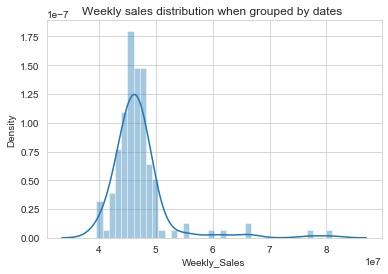

In [21]:
sns.distplot(final_data.groupby(['Date'])['Weekly_Sales'].sum())
sns.set(rc={'figure.figsize':(15.7,6.27)})
plt.title('Weekly sales distribution when grouped by dates ')

Basically we have grouped by dates and then calculated the total weekly sales at that date as dates are repeated ,

it comprises of all store,department sales at that date and used distribution plot to view  mean weekly value.

Text(0, 0.5, 'Weekly sales ')

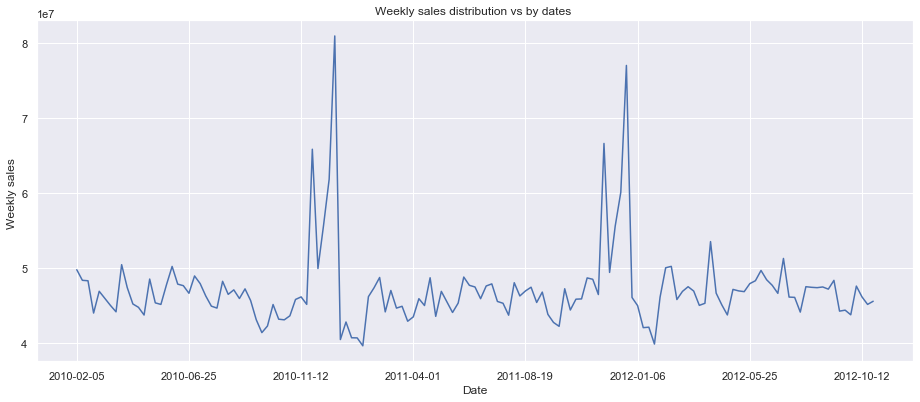

In [22]:
final_data.groupby(['Date'])['Weekly_Sales'].sum().plot()
plt.title('Weekly sales distribution vs by dates ')
plt.ylabel('Weekly sales ')

### Inference
1.We can see that in month of November and December weekly sales are going very high which means that maybe holidays that are in November and December are creating a huge impact on weekly sales

2.There is slight dip in sales in last december and start of january also

3.There is a seasonality in plot of weekly sales over the period of time which can be easily seen by plot

4.Average weekly sales are fluctuating around 4.5*10^7 

#### c.)Univariate analysis on markdown1,markdown2,markdown3,markdown4,markdown5 column

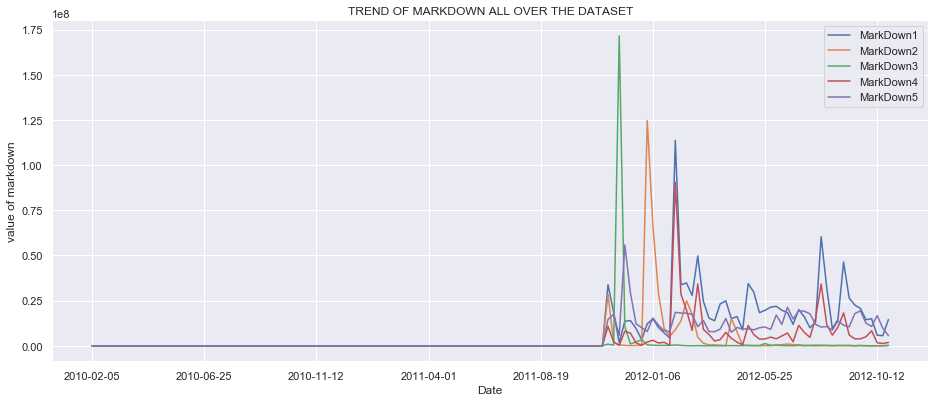

In [23]:
final_data.groupby(['Date'])['MarkDown1'].sum().plot(label='MarkDown1')
final_data.groupby(['Date'])['MarkDown2'].sum().plot(label='MarkDown2')
final_data.groupby(['Date'])['MarkDown3'].sum().plot(label='MarkDown3')
final_data.groupby(['Date'])['MarkDown4'].sum().plot(label='MarkDown4')
final_data.groupby(['Date'])['MarkDown5'].sum().plot(label='MarkDown5')
plt.title('TREND OF MARKDOWN ALL OVER THE DATASET')
plt.ylabel('value of markdown')
plt.legend()

### Inference
1.We can see that till December 2011 there were no markdown values available

2.All markdown values are giving a spike at start like in month of january 2012 and in start markdown 3 is highest but after start markdown 1 is high throughout dataset


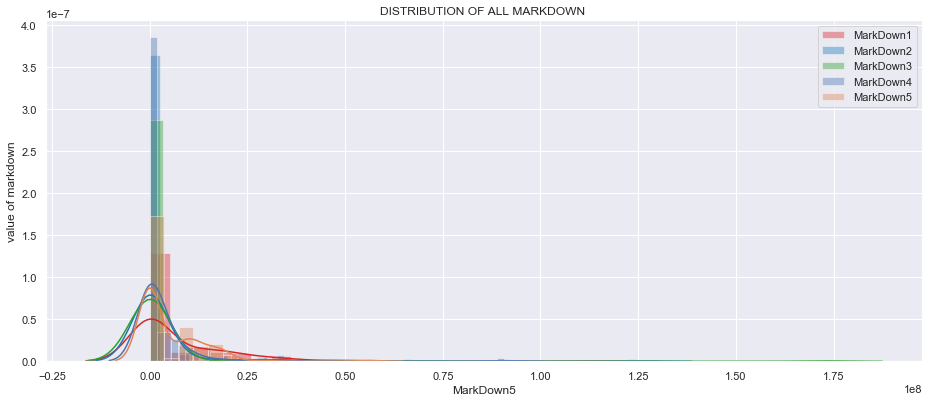

In [24]:
sns.distplot(final_data.groupby(['Date'])['MarkDown1'].sum(),label='MarkDown1',color="tab:red")
sns.distplot(final_data.groupby(['Date'])['MarkDown2'].sum(),label='MarkDown2',color="tab:blue")
sns.distplot(final_data.groupby(['Date'])['MarkDown3'].sum(),label='MarkDown3',color="tab:green")
sns.distplot(final_data.groupby(['Date'])['MarkDown4'].sum(),label='MarkDown4')
sns.distplot(final_data.groupby(['Date'])['MarkDown5'].sum(),label='MarkDown5')
plt.title('DISTRIBUTION OF ALL MARKDOWN ')
plt.ylabel('value of markdown')
plt.legend()

1.Markdown 3 has more values as compared to other markdown when we are seeing in 200000 datapoints 
So,we can conclude that it has created a biggest impact as compared to other markdown on weekly sales.

2.We will consider it as a important feature in determining weekly sales.We will use correlation matrix 
also see whether this inference is true or not

#### d.)Univariate analysis on type column

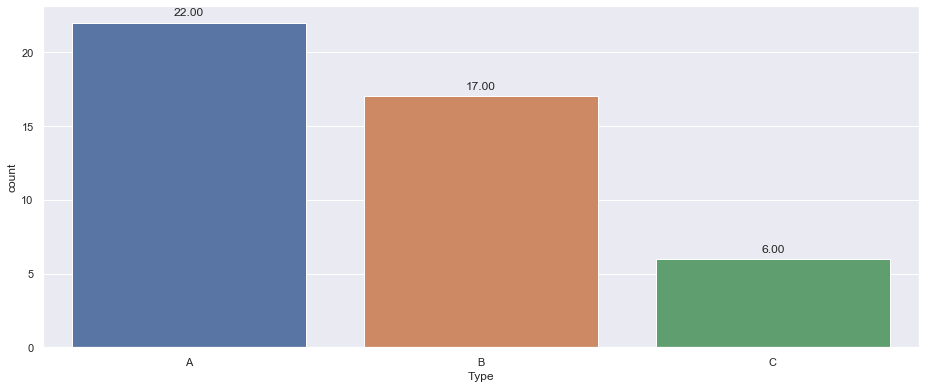

In [25]:
splot = sns.countplot(stores_data.Type)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',va = 'center', xytext = (0, 10), textcoords = 'offset points')

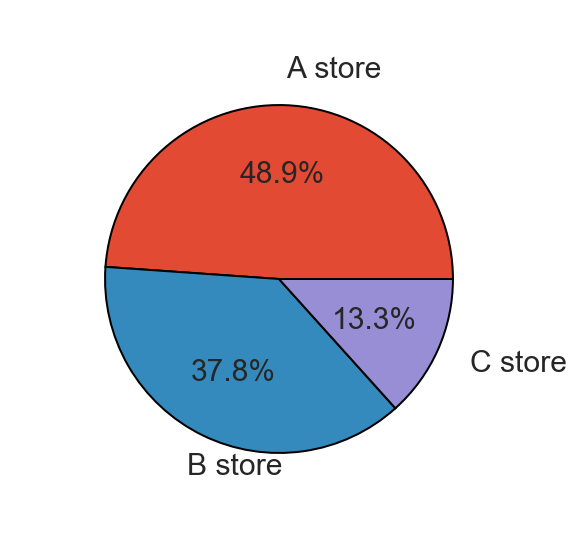

In [26]:
sorted_type = final_data.groupby('Type')
plt.style.use('ggplot')
labels=['A store','B store','C store']
sizes=sorted_type.describe()['Size'].round(1)
sizes=[(22/(17+6+22))*100,(17/(17+6+22))*100,(6/(17+6+22))*100] # convert to the proportion
fig, axes = plt.subplots(1,1, figsize=(10,10))
wprops={'edgecolor':'black',
      'linewidth':2}
tprops = {'fontsize':30}
axes.pie(sizes,
        labels=labels,
        explode=(0.0,0,0),
        autopct='%1.1f%%',
        pctdistance=0.6,
        labeldistance=1.2,
        wedgeprops=wprops,
        textprops=tprops,
        radius=0.8,
        center=(0.5,0.5))
plt.show()

### Key analysis
We came to know that Type A stores have their medians higher than any other medians in other store types, so the weekly sales for store type A is more than other store types.

There are a total of 3 types of stores: Type A, Type Band Type C.

There are 45 stores in total.By piechart and barplot, we can say that type A store is the largest store and C is the smallest.

### Analysis of 'Type' column with weekly sales

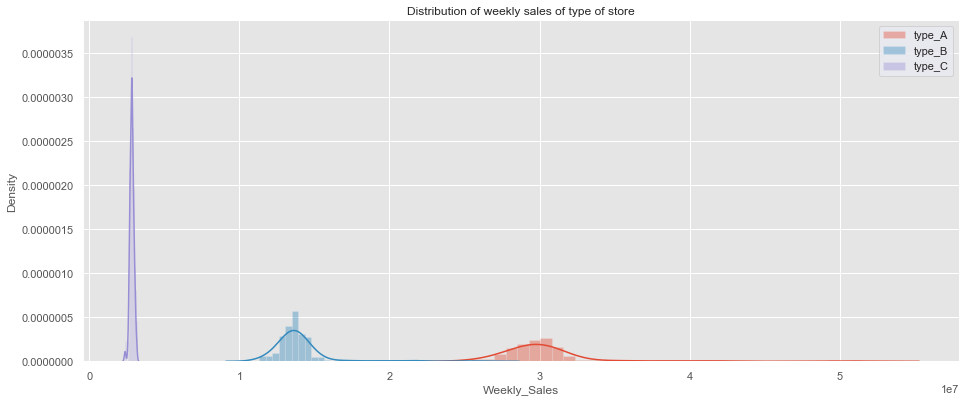

In [27]:
raw=final_data.groupby(['Type','Date','IsHoliday'])['Weekly_Sales'].sum().reset_index()
type_A=raw[raw['Type']=='A']
type_B=raw[raw['Type']=='B']
type_C=raw[raw['Type']=='C']
sns.distplot(type_A['Weekly_Sales'],label='type_A')
sns.distplot(type_B['Weekly_Sales'],label='type_B')
sns.distplot(type_C['Weekly_Sales'],label='type_C')
sns.set(rc={'figure.figsize':(12.7,6.27)})
plt.legend()
plt.title('Distribution of weekly sales of type of store')
plt.show()

### Inference
1.It is very easy to seperate the values of weekly sales values of all type of store as the values are completly in different zones

2.Mean value of type A is around 3*10^7 and is guassian distributed 

3.Mean value of type B is around 1.5*10^7 and is guassian distributed 

4.Mean value of type C is around 0.2*10^7 and is guassian distributed .Its variance is also very less

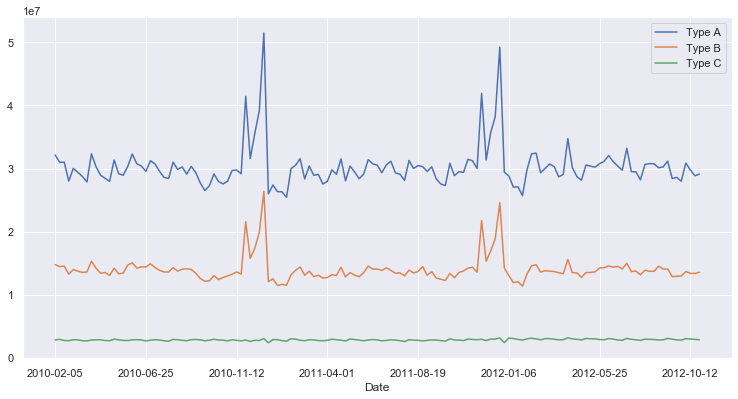

In [28]:
final_data[final_data['Type']=='A'].groupby(['Date'])['Weekly_Sales'].sum().plot(label='Type A')
final_data[final_data['Type']=='B'].groupby(['Date'])['Weekly_Sales'].sum().plot(label='Type B')
final_data[final_data['Type']=='C'].groupby(['Date'])['Weekly_Sales'].sum().plot(label='Type C')
sns.set(rc={'figure.figsize':(18.7,8.27)})
plt.legend()

1.There is sesonality in weekly sales of Type A and Type B with increase in weekly sales around november and december of each year

2.Type C store weekly sales doesn't rise just like type A and type B ,it is flucating around its mean values only

Text(0, 0.5, 'Weekly sales ')

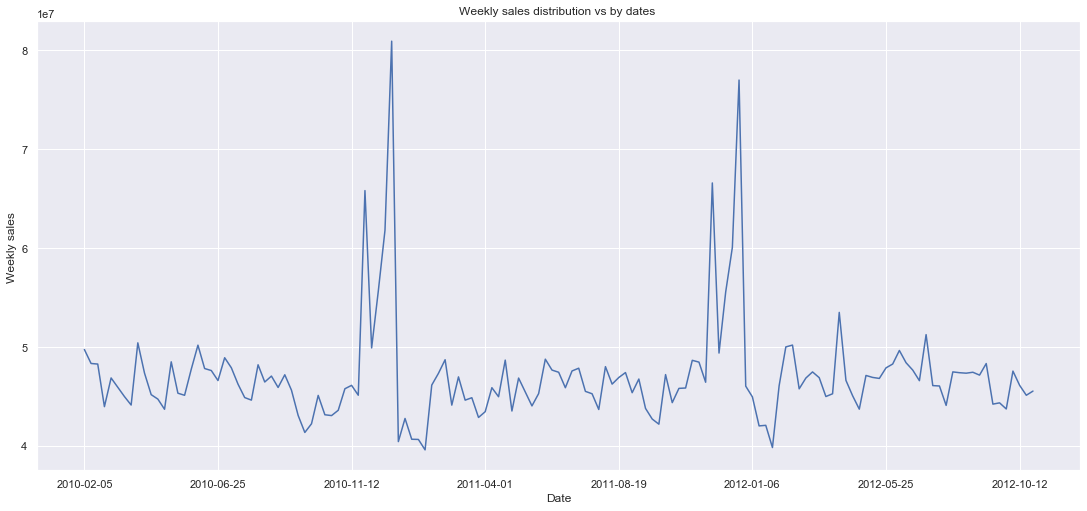

In [29]:
final_data.groupby(['Date'])['Weekly_Sales'].sum().plot()
plt.title('Weekly sales distribution vs by dates ')
plt.ylabel('Weekly sales ')

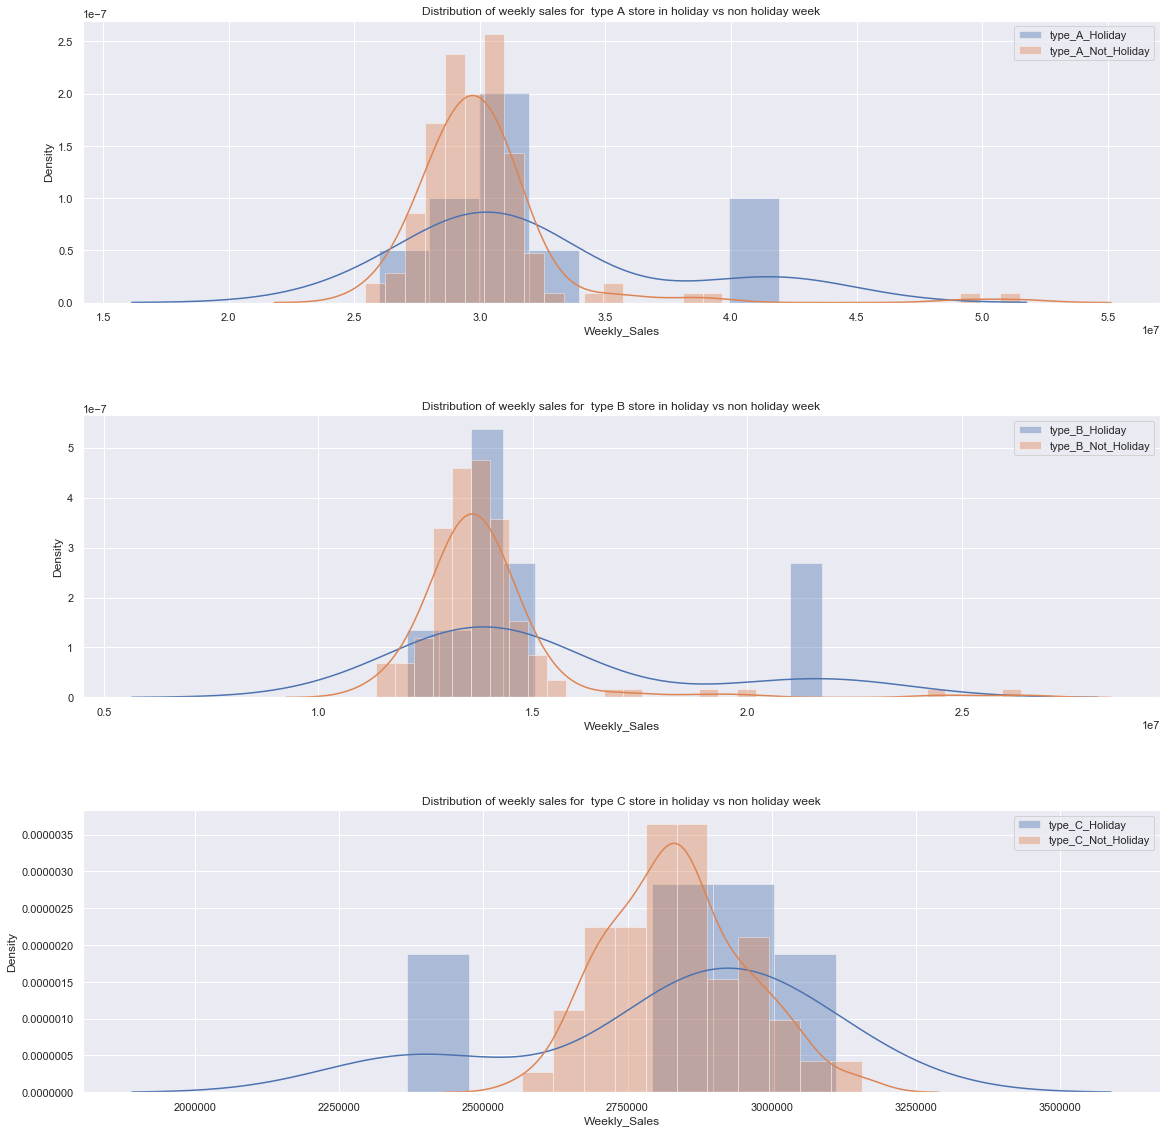

In [30]:
raw=final_data.groupby(['Type','Date','IsHoliday'])['Weekly_Sales'].sum().reset_index()
plt.title('Distribution of weekly sales of type of store')
plt.figure(1)   
plt.subplot(311) 
plt.title('Distribution of weekly sales for  type A store in holiday vs non holiday week')
type_A_H=raw[(raw['Type']=='A') & (raw['IsHoliday']==True)]
type_A_NH=raw[(raw['Type']=='A') & (raw['IsHoliday']==False)]
sns.distplot(type_A_H['Weekly_Sales'],label='type_A_Holiday')
sns.distplot(type_A_NH['Weekly_Sales'],label='type_A_Not_Holiday')
plt.legend()
plt.subplot(312) 
plt.title('Distribution of weekly sales for  type B store in holiday vs non holiday week')
type_B_H=raw[(raw['Type']=='B') & (raw['IsHoliday']==True)]
type_B_NH=raw[(raw['Type']=='B') & (raw['IsHoliday']==False)]
sns.distplot(type_B_H['Weekly_Sales'],label='type_B_Holiday')
sns.distplot(type_B_NH['Weekly_Sales'],label='type_B_Not_Holiday')
plt.legend()
plt.subplot(313) 
plt.title('Distribution of weekly sales for  type C store in holiday vs non holiday week')
type_C_H=raw[(raw['Type']=='C') & (raw['IsHoliday']==True)]
type_C_NH=raw[(raw['Type']=='C') & (raw['IsHoliday']==False)]
sns.distplot(type_C_H['Weekly_Sales'],label='type_C_Holiday')
sns.distplot(type_C_NH['Weekly_Sales'],label='type_C_Not_Holiday')
sns.set(rc={'figure.figsize':(12.7,6.27)})
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.legend()
plt.show()

1.All type of store's weekly sales are almost following normal distribution

2.All type of store's weekly sales for holiday and non holiday week are almost overlaping but some outliers can also be seen and that make a sense also because on holiday week sales may rise from its normal sales and sometime may decrease also as  people tend to do shopping just before the holiday so if  holiday is the first day of that week then sales may have fallen down drastically.

### Distribution of Fuel_Price all over the dataset

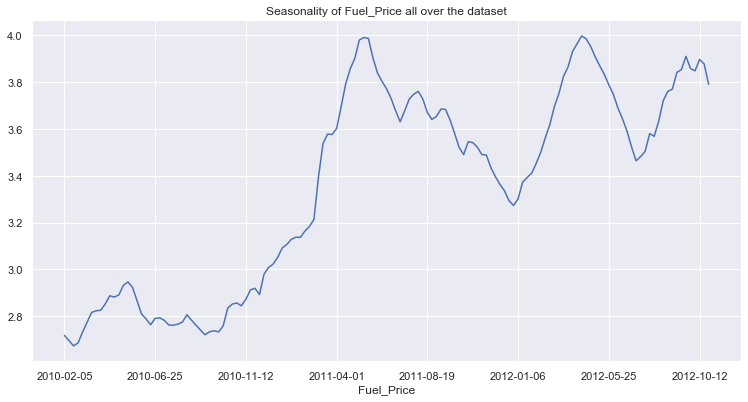

In [31]:
final_data[['Date','Fuel_Price']].groupby(['Date'])['Fuel_Price'].agg('mean').plot(color='b')
plt.title('Seasonality of Fuel_Price all over the dataset')
plt.xlabel('Fuel_Price')
sns.set(rc={'figure.figsize':(18.7,6.27)})

Text(0, 0.5, 'weekly sales')

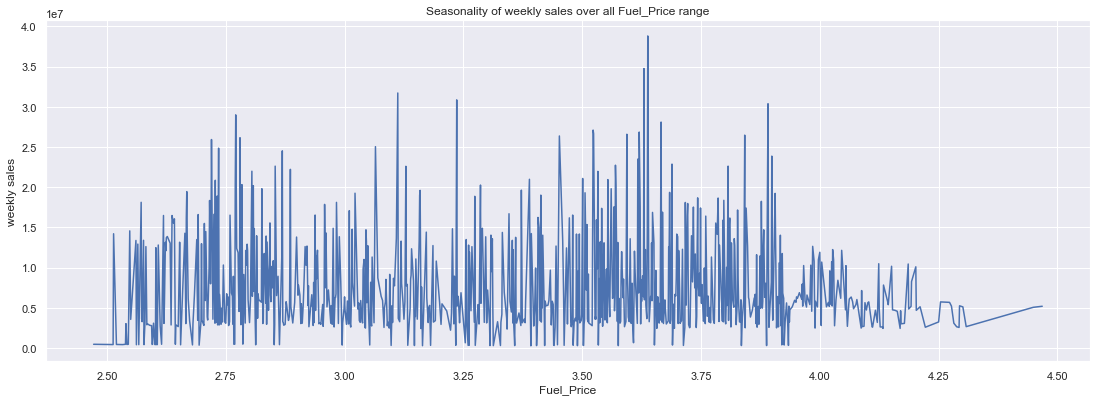

In [32]:
final_data[['Fuel_Price','Weekly_Sales']].groupby(['Fuel_Price'])['Weekly_Sales'].sum().plot()
plt.title('Seasonality of weekly sales over all Fuel_Price range')
plt.ylabel('weekly sales')

### Inference
1.Fuel price has gone high after December 2010 to a very high level

2.There is a seasonal trend in the fuel price all over the dataset

3.Weekly sales are low when fuel price is above 4 and highest when it is between 3.5 to 3.9

### Distribution of temperature all over the dataset

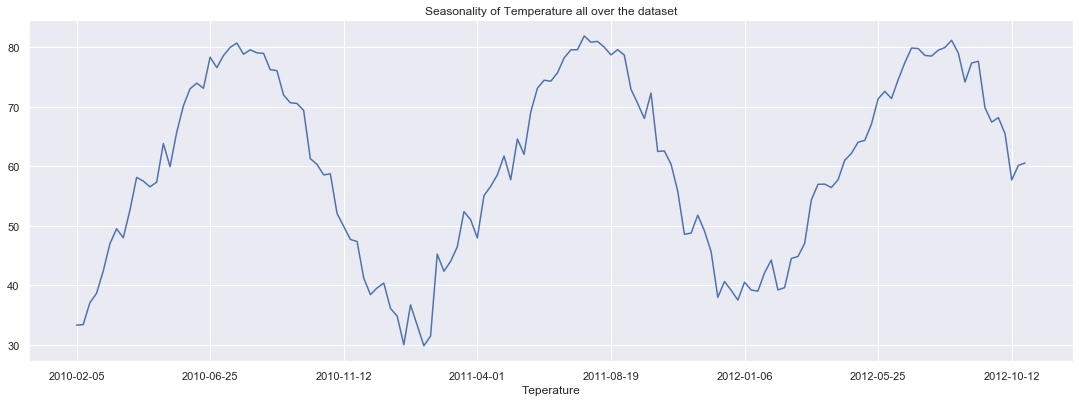

In [33]:
final_data[['Date','Temperature']].groupby(['Date'])['Temperature'].agg('mean').plot(color='b')
plt.title('Seasonality of Temperature all over the dataset')
plt.xlabel('Teperature')
sns.set(rc={'figure.figsize':(18.7,6.27)})

Text(0, 0.5, 'weekly sales')

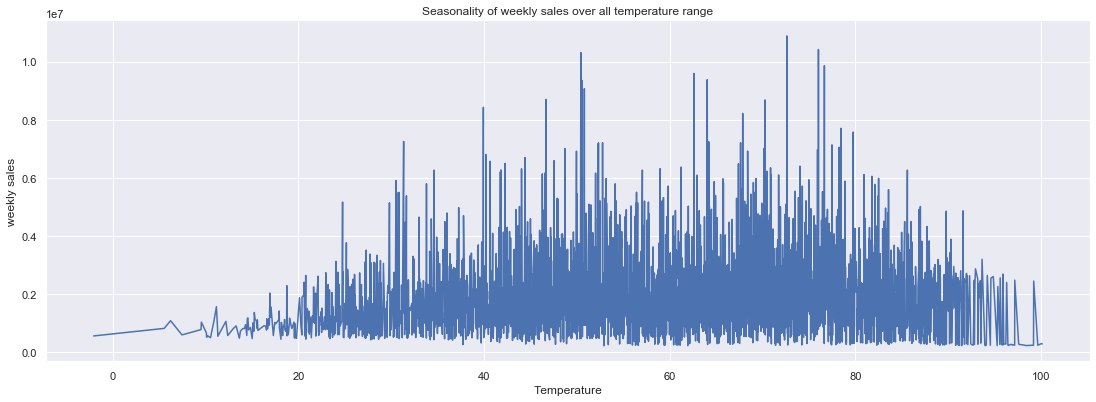

In [34]:
final_data[['Temperature','Weekly_Sales']].groupby(['Temperature'])['Weekly_Sales'].sum().plot()
plt.title('Seasonality of weekly sales over all temperature range')
plt.ylabel('weekly sales')

### Inference
1.Weekly sales  has gone high after temperature 40 and are highest in range of 60-80 

2.There is a seasonal trend in the temperature  all over the dataset

3.Temperature are going high in june july of every year and becaming low in november ,december

## 2. ANALYSIS OF SOME OTHER FEATURES VS WEEKLY SALES

In [35]:
final_data.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315


#### a.)weekly sales vs store number

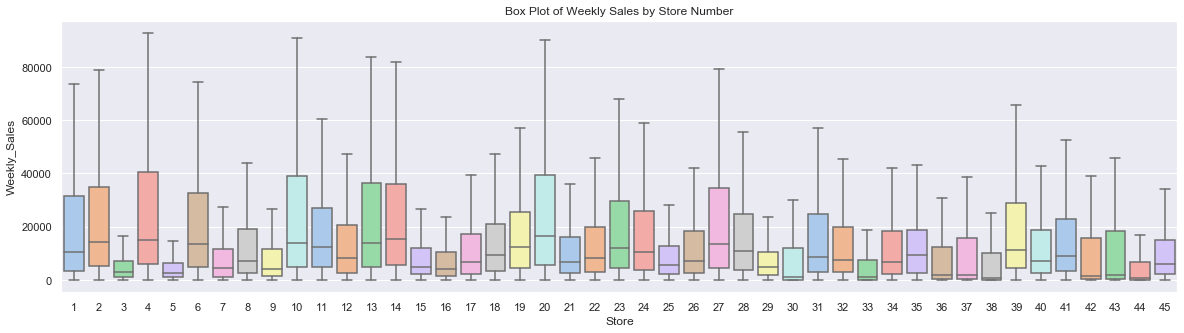

In [36]:
data1 = pd.concat([final_data['Store'], final_data['Weekly_Sales']], axis=1)
plt.figure(figsize=(20,5))
plt.title('Box Plot of Weekly Sales by Store Number')
fig = sns.boxplot(x='Store', y='Weekly_Sales', data=data1, showfliers=False,palette='pastel')

1.We can see that store 4,10 and 20 has highest weekly sales throughout and average weekly sales is around 10000

2.We can plot type als0 with store to see what is the type of store which are creating big impact on weekly sales

#### b.)weekly sales vs store number and its type

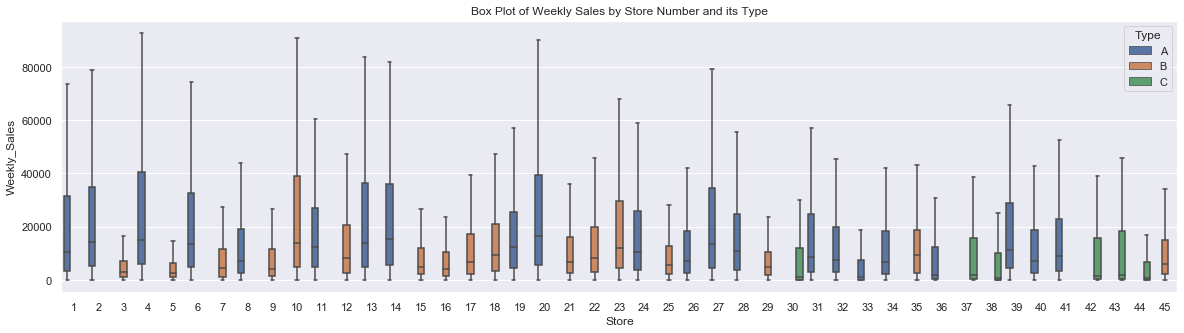

In [37]:
data2 = pd.concat([final_data['Store'], final_data['Weekly_Sales'], final_data['Type']], axis=1)
plt.figure(figsize=(20,5))
plt.title('Box Plot of Weekly Sales by Store Number and its Type')
fig = sns.boxplot(x='Store', y='Weekly_Sales', data=data2, showfliers=False, hue='Type')

1.We can interpret from box plot that mean of most of the type A store are higher as compared to type B and C .

2.Therefore we can say that type A store will be dominant in overall weekly sales from each store

#### c.)weekly sales vs department

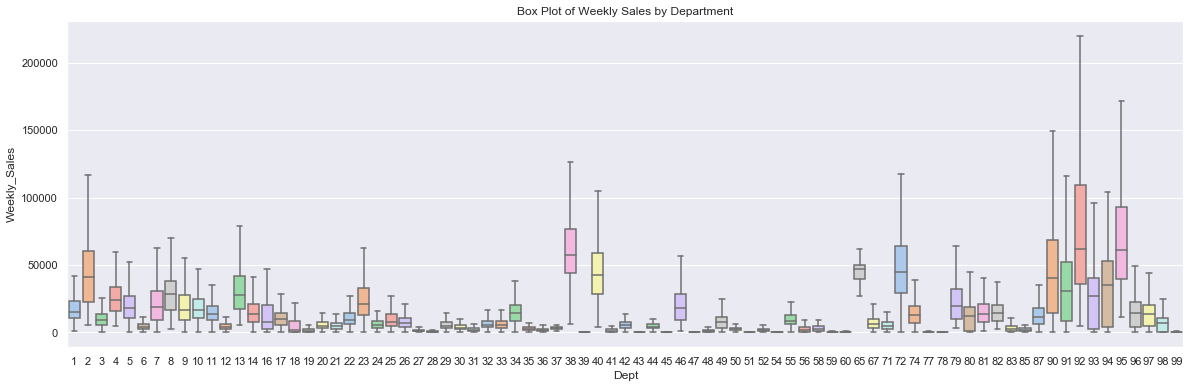

In [38]:
data3 = pd.concat([final_data['Dept'], final_data['Weekly_Sales']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Department')
fig = sns.boxplot(x='Dept', y='Weekly_Sales', data=data3, showfliers=False,palette='pastel')

we can see that department 38,92,95 are having weekly sales above 50000 rest are below 5000 only

#### d.)weekly sales vs store with hue as holiday

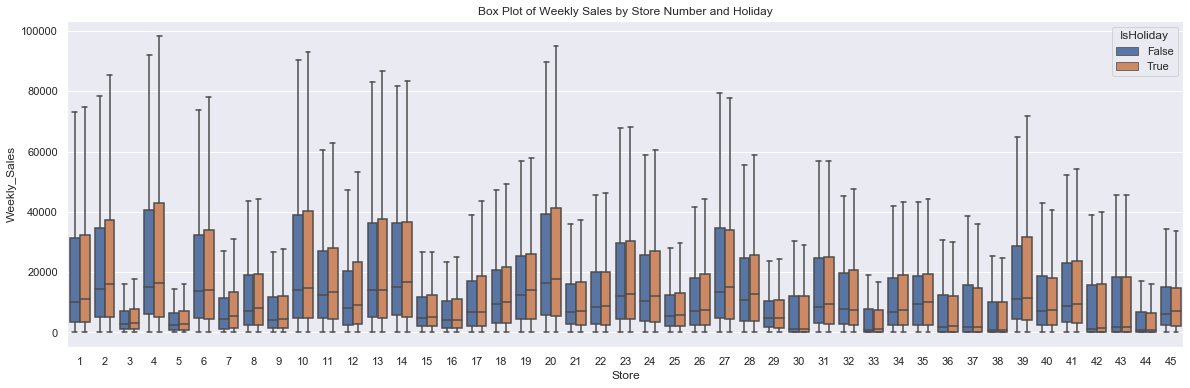

In [39]:
data4 = pd.concat([final_data['Store'], final_data['Weekly_Sales'], final_data['IsHoliday']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Store Number and Holiday')
fig = sns.boxplot(x='Store', y='Weekly_Sales', data=data4, showfliers=False, hue='IsHoliday')

1.From plot we can see that weekly sales of all store on holiday is higher as compared to non holiday week.

2.So,yes holiday weeks are creating huge impact and can be treated as important feature also in determining the weekly sales

#### e.)weekly sales vs isholiday

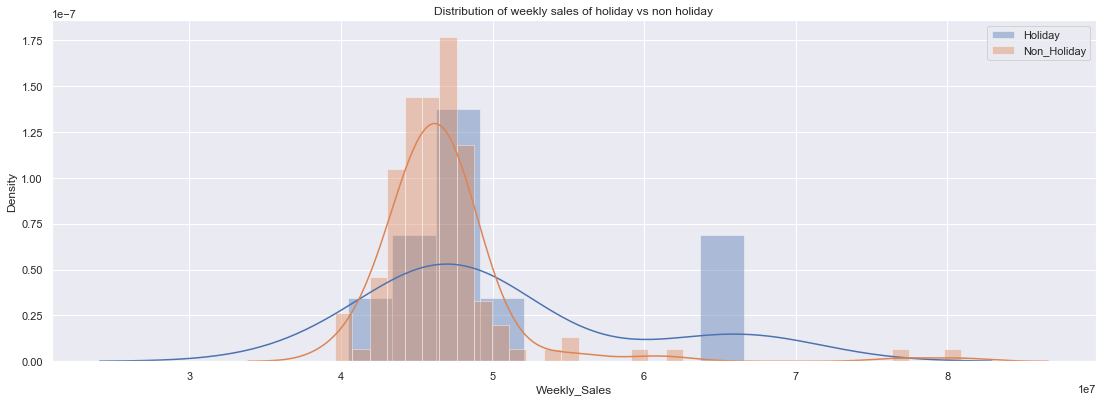

In [40]:
raw=final_data.groupby(['Date','IsHoliday'])['Weekly_Sales'].sum().reset_index()
Holiday=raw[raw['IsHoliday']==True]
Non_Holiday=raw[raw['IsHoliday']==False]
sns.distplot(Holiday['Weekly_Sales'],label='Holiday')
sns.distplot(Non_Holiday['Weekly_Sales'],label='Non_Holiday')
sns.set(rc={'figure.figsize':(12.7,6.27)})
plt.legend()
plt.title('Distribution of weekly sales of holiday vs non holiday')
plt.show()

Text(0.5, 1.0, 'weekly sales mean for holiday and non_holdiay')

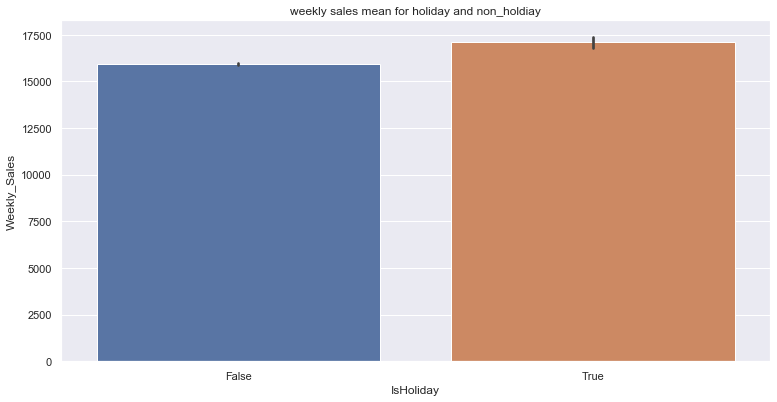

In [41]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=final_data)
# sns.set(rc={'figure.figsize':(4.7,3.27)})
plt.title('weekly sales mean for holiday and non_holdiay')

In [42]:
print('Total weekly sales for non holiday week:',final_data[final_data.IsHoliday==False].Weekly_Sales.sum())
print('Total weekly sales for  holiday week   : ',final_data[final_data.IsHoliday==True].Weekly_Sales.sum())

Total weekly sales for non holiday week: 6231999613.52
Total weekly sales for  holiday week   :  505307535.15


### Conclusion
We can conclude two things from the weekly sales vs isholiday

1.Mean value of weekly sales for non holiday week is less as compared to holiday week

2.Total weekly sales of non holiday week is more as compared to holiday week and its ovious
because non holdiay weeks are much more than holiday week

3.Both weekly sales for holiday as weel as non holdiay week follows normal distribution

4.weekly sales of non holiday week are widely spread means it variance is high and has some outliers also.

In [43]:
features = ['Store','Dept','Weekly_Sales', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Size','Type']
df = final_data[features]

In [44]:
df['Store'] = 'str' + df['Store'].astype(str)
df['Dept'] = 'str' + df['Dept'].astype(str)

In [45]:
!pip install dython

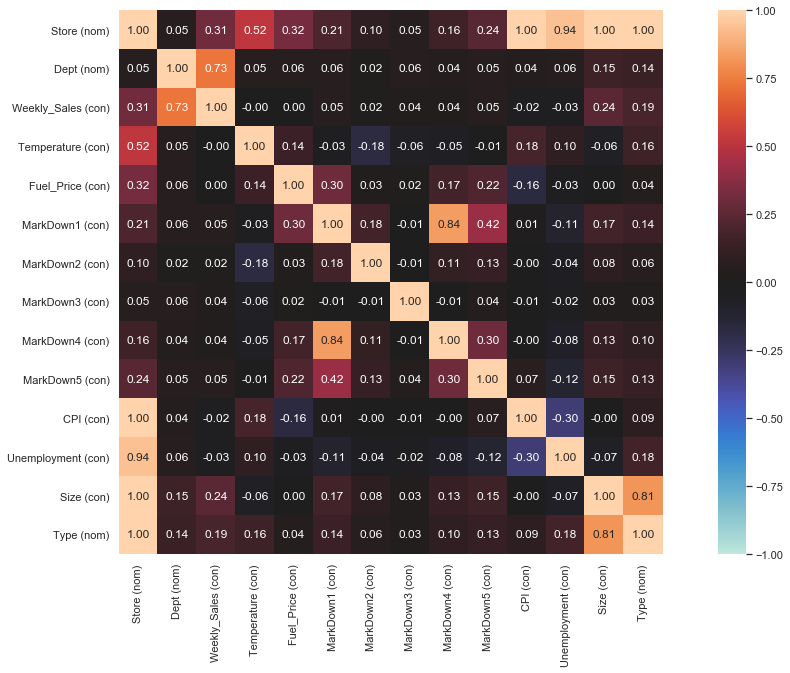

In [46]:
#!pip install dython
from dython import nominal
nominal.associations(df,figsize=(20,10),mark_columns=True);

### Conclusion from correlation matrix
1. correlation between Weekly sales and Dept =0.73
2. correlation between Weekly sales and Store =0.31
3. correlation between Weekly sales and Type =0.19
4. correlation between Weekly sales and size =0.24
5. correlation between Weekly sales and Markdown1 =0.05
6. correlation between Weekly sales and Markdown2 =0.02
7. correlation between Weekly sales and Markdown3 =0.04
8. correlation between Weekly sales and Markdown4 =0.04
9. correlation between Weekly sales and Markdown5 =0.05

Two conclusion we can derive from here :

a.Feature importance goes like Dept>Store>Size>Type>Markdown=Markdown5>Markdown3=Markdown4>Markdown2